Import packages

In [1]:
##Logistic regression, random forest and XGBoost are used to predict home credit default

import pandas as pd
import numpy as np
import xgboost
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor

Read data

In [2]:
application_train = pd.read_csv('application_train.csv') 
application_test = pd.read_csv('application_test.csv') 

Prediction model of train data and test data

Overview of data distribution and types

In [3]:
application_train.describe()

##Extremely large values and missing values can be seen from the statistics

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [4]:
print(application_train.dtypes.value_counts())

##For categorical values, dummy variables are needed for training

float64    65
int64      41
object     16
Name: count, dtype: int64


In [5]:
application_test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


In [6]:
print(application_test.dtypes.value_counts())

float64    65
int64      40
object     16
Name: count, dtype: int64


Estimate the missing values

In [7]:
def missing_values_table(df, threshold = 0.6):
        # Calculate the missing value percentage
        mis_val = df.isnull().sum()
        mis_val_per = 100 * df.isnull().sum() / len(df)
        
        # Make a table and rename the columns
        mis_val_table = pd.concat([mis_val, mis_val_per], axis=1).rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
               
        # Sort the table by percentage of missing descending
        mis_val_table = mis_val_table[
            mis_val_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Drop the columns with more than 60% of missing values
        missing_cols = list(mis_val_table.index[mis_val_table['% of Total Values'] > threshold*100])
        dropped_df = df.drop(columns = missing_cols)

        # Print the number of columns with missing values and columns after removal
        print (mis_val_table.shape[0], dropped_df.shape[1])
        return dropped_df

In [8]:
missing_values_application_train = missing_values_table(application_train)

67 105


In [9]:
missing_values_application_test = missing_values_table(application_test)

64 104


Encoding the categorical variables

In [10]:
# Find out the number of unique values of categorical variables
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [11]:
application_test.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [12]:
# Encoding the object columns with less than 2 unique values
le = LabelEncoder()

for col in application_train:
    if application_train[col].dtype == 'object':
        if len(list(application_train[col].unique())) <= 2:
            le.fit(application_train[col])
            application_train[col] = le.transform(application_train[col])

for col in application_test:
    if application_test[col].dtype == 'object':
        if len(list(application_test[col].unique())) <= 2:
            le.fit(application_test[col])
            application_test[col] = le.transform(application_test[col])

In [13]:
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CODE_GENDER                    3
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [14]:
application_test.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [15]:
# Using dummy variables for columns with more than 2 unique values
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

Removing outliers

Check the data distribution of application train and application test to determine the threshold of outliers and remove the outliers.

In [16]:
##Deal with the outliers in application_train.csv
##The maximum value of AMT_INCOME_TOTAL is 1.17E8 which is significantly high and may be an abnormal value
##For the time data, negative numerical values should be corrected to positive values.
application_train.drop(application_train[application_train['AMT_INCOME_TOTAL']>=10000000].index,axis=0)

application_train['DAYS_BIRTH']=abs(application_train['DAYS_BIRTH'])
application_train['DAYS_EMPLOYED']=abs(application_train['DAYS_EMPLOYED'])
application_train['DAYS_REGISTRATION']=abs(application_train['DAYS_REGISTRATION'])
application_train['DAYS_ID_PUBLISH']=abs(application_train['DAYS_ID_PUBLISH'])
application_train['DAYS_LAST_PHONE_CHANGE']=abs(application_train['DAYS_LAST_PHONE_CHANGE'])

In [17]:
##Deal with the outliers in application_test.csv
application_test['DAYS_BIRTH']=abs(application_test['DAYS_BIRTH'])
application_test['DAYS_EMPLOYED']=abs(application_test['DAYS_EMPLOYED'])
application_test['DAYS_REGISTRATION']=abs(application_test['DAYS_REGISTRATION'])
application_test['DAYS_ID_PUBLISH']=abs(application_test['DAYS_ID_PUBLISH'])
application_test['DAYS_LAST_PHONE_CHANGE']=abs(application_test['DAYS_LAST_PHONE_CHANGE'])

Replace missing value with the mean value of other data

In [18]:
for col in application_train:
    if application_train[col].dtype != 'object':
        train_mean = np.mean(application_train[col].dropna())
        application_train[col].replace({np.nan:train_mean}, inplace = True)

for col in application_test:
    if application_test[col].dtype != 'object':
        test_mean = np.mean(application_test[col].dropna())
        application_test[col].replace({np.nan:test_mean}, inplace = True)

Extract index, features and label from train data and test data

In [19]:
train_index = application_train['SK_ID_CURR']
train_label = application_train['TARGET']
train_features = application_train.drop(columns = ['SK_ID_CURR', 'TARGET'])

In [20]:
test_index = application_test['SK_ID_CURR']
test_features = application_test.drop(['SK_ID_CURR'], axis=1)

In [21]:
# Align two train features and test features on their axes with the intersection of keys.
train_features, test_features = train_features.align(test_features, join = 'inner', axis = 1) 

print(train_features.shape)
print(test_features.shape)
print(train_label.shape)

(307511, 236)
(48744, 236)
(307511,)


Scaling feature to the given range

In [22]:
feature_name = train_features.columns
mms = MinMaxScaler()
train_features = mms.fit_transform(train_features)
x_test = mms.fit_transform(test_features)

Split the training data to training set and validation set

In [23]:
x_train, x_vali, y_train, y_vali = train_test_split(train_features, train_label, test_size=0.2, random_state=2)
print(x_train.shape,x_vali.shape,y_train.shape,y_vali.shape)

(246008, 236) (61503, 236) (246008,) (61503,)


Method 1: logistic regression

In [24]:
##Model training of logistic regression
lr = LogisticRegression()
lr_model = lr.fit(x_train, y_train)
lr_vali = lr.predict_proba(x_vali)[:,1]

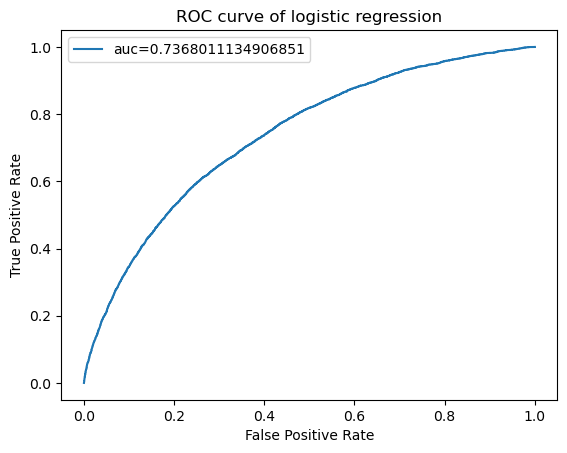

In [25]:
##Plot the ROC curve of logistic regression

fpr, tpr, threshold = metrics.roc_curve(y_vali, lr_vali)
lr_auc = roc_auc_score(y_vali, lr_vali) 
plt.plot(fpr, tpr, label = "auc=" + str(lr_auc)) 
plt.ylabel('True Positive Rate') 
plt.xlabel('False Positive Rate') 
plt.title('ROC curve of logistic regression')
plt.legend()
plt.show()

In [26]:
##Export data for submission to Kaggle test
lr_test = lr.predict_proba(x_test)[:, 1]
pd.DataFrame({'SK_ID_CURR':test_index, 'TARGET':lr_test}).to_csv('LR_Li.csv',index = False)

Method 2: random forest

In [27]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
rf.fit(x_train, y_train)
rf_vali = rf.predict_proba(x_vali)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.2s finished


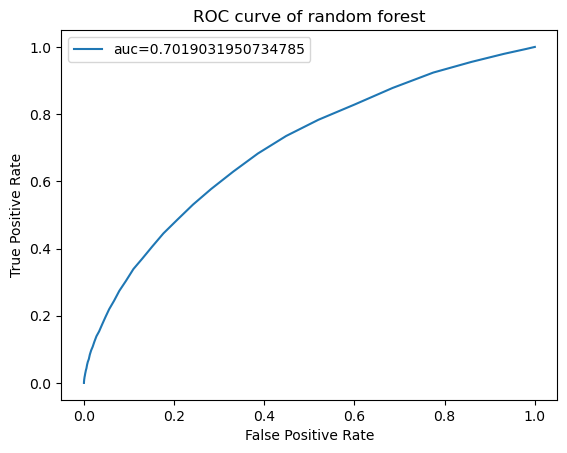

In [28]:
fpr, tpr, threshold = metrics.roc_curve(y_vali, rf_vali)
rf_auc = roc_auc_score(y_vali, rf_vali) 
plt.plot(fpr, tpr, label = "auc=" + str(rf_auc)) 
plt.ylabel('True Positive Rate') 
plt.xlabel('False Positive Rate') 
plt.title('ROC curve of random forest')
plt.legend()
plt.show()

In [29]:
##Export data for submission to Kaggle test
rf_test = rf.predict_proba(x_test)[:, 1]
pd.DataFrame({'SK_ID_CURR':test_index, 'TARGET':rf_test}).to_csv('RF_Li.csv',index = False)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.8s finished


Method 3: xgboost

In [30]:
xgb_model = xgboost.XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=3)
xgb_model.fit(x_train, y_train)
xbg_vali = xgb_model.predict_proba(x_vali)[:,1]

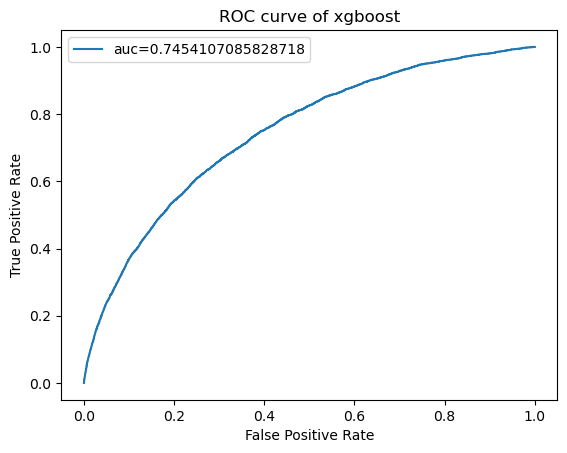

In [31]:
fpr, tpr, threshold = metrics.roc_curve(y_vali, xbg_vali)
xgb_auc = roc_auc_score(y_vali, xbg_vali) 
plt.plot(fpr, tpr, label = "auc=" + str(xgb_auc)) 
plt.ylabel('True Positive Rate') 
plt.xlabel('False Positive Rate') 
plt.title('ROC curve of xgboost')
plt.legend()
plt.show()

In [32]:
##Export data for submission to Kaggle test
xgb_test = xgb_model.predict_proba(x_test)[:, 1]
pd.DataFrame({'SK_ID_CURR':test_index, 'TARGET':xgb_test}).to_csv('XGB_Li.csv',index = False)

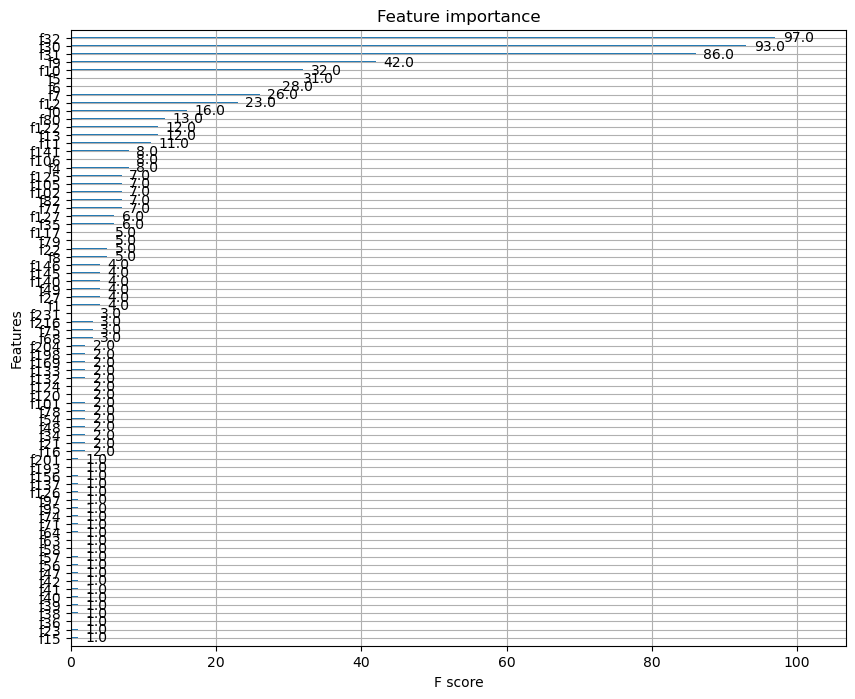

In [33]:
##Feature importance plot

fig, ax = plt.subplots(figsize=(10, 8))
xgboost.plot_importance(xgb_model, ax=ax)
plt.show()

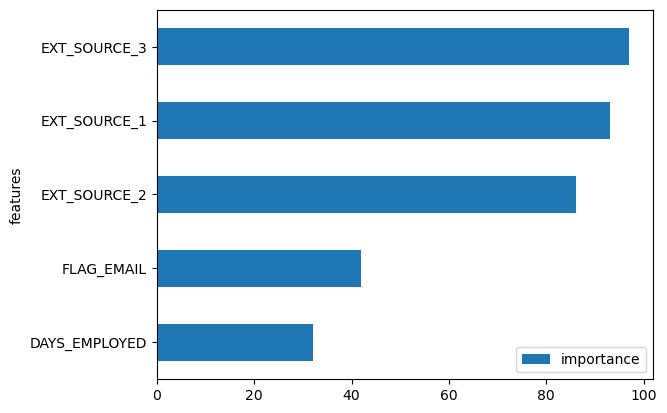

In [34]:
importance_xgb=[97,93,86,42,32]
list_xgb=[32,30,31,19,10]
feature_xgb_list=feature_name[list_xgb]
feature_importance_xgb = pd.DataFrame(feature_xgb_list,columns=['features'])
feature_importance_xgb['importance']=importance_xgb
ax = feature_importance_xgb.sort_values(by=['importance'],ascending=True).plot.barh(x='features',y='importance')
plt.show()